## Урок 5. Feature Engineering, Feature Selection, part I

Продолжим работу с данными, которые были использованы в ДЗ2 и 3, продолжим решать задачу обнаружения мошеннических транзакций, что позволит получить полное решение задачи / полный пайплайн.

Задание 0: выбрать любую модель машинного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats.mstats import winsorize
import warnings
import xgboost as xgb
from typing import List, Optional

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, roc_auc_score
 
warnings.simplefilter("ignore")
%matplotlib inline

In [ ]:
# from google.colab import drive

In [ ]:
# drive.mount("/content/for_colab")

In [ ]:
# !unzip "/content/for_colab/My Drive/for_colab/assignment2_data.zip" -d /content/data

In [ ]:
data = pd.read_csv("data/assignment_2_train.csv")
test_data = pd.read_csv("data/assignment_2_test.csv")
data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.nunique().sort_values()

V107                  1
V14                   2
V1                    2
M9                    2
M8                    2
                  ...  
card1              9496
V127              10259
V307              14863
TransactionDT    173460
TransactionID    180000
Length: 394, dtype: int64

In [ ]:
x_train, x_valid = train_test_split(
    data.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.70, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_test = (test_data.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = test_data["isFraud"]

In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 377 cols
x_valid.shape = 54001 rows, 377 cols
x_test.shape = 100001 rows, 377 cols


In [ ]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648969	test-auc:0.622315
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.794601	test-auc:0.756904
[20]	train-auc:0.8344	test-auc:0.804545
[30]	train-auc:0.859773	test-auc:0.839944
[40]	train-auc:0.869723	test-auc:0.849625
[50]	train-auc:0.878079	test-auc:0.853983
[60]	train-auc:0.883288	test-auc:0.855621
[70]	train-auc:0.88567	test-auc:0.856661
[80]	train-auc:0.889096	test-auc:0.857535
[90]	train-auc:0.89214	test-auc:0.858782
[100]	train-auc:0.893794	test-auc:0.859435
[110]	train-auc:0.895468	test-auc:0.860087
[120]	train-auc:0.896807	test-auc:0.860383
[130]	train-auc:0.898087	test-auc:0.860523
[140]	train-auc:0.898303	test-auc:0.860647
[150]	train-auc:0.898303	test-auc:0.860647
Stopping. Best iteration:
[132]	train-auc:0.898303	test-auc:0.860647



In [ ]:
train_roc_auc_score_0 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_0 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_0 = roc_auc_score(y_test, model.predict(dtest))

In [ ]:
print('train: %.4f' % train_roc_auc_score_0)
print('valid: %.4f' % valid_roc_auc_score_0)
print('test: %.4f' % test_roc_auc_score_0)

train: 0.8983
valid: 0.8843
test: 0.8606


Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.


In [ ]:
import time
from datetime import datetime, date

In [ ]:
base_time_dt = time.mktime(date(2017, 12, 1).timetuple())
print(base_time_dt,"-", datetime.fromtimestamp(base_time_dt).strftime('%Y-%m-%d'))

1512086400.0 - 2017-12-01


In [ ]:
data["TransactionDT_date"] = pd.to_datetime(data.TransactionDT + base_time_dt, unit='s')

In [ ]:
data["TransactionDT_year"] = data["TransactionDT_date"].dt.year
data["TransactionDT_month"] = data["TransactionDT_date"].dt.month
data["TransactionDT_weekday"] = data["TransactionDT_date"].dt.weekday
data["TransactionDT_hour"] = data["TransactionDT_date"].dt.hour
data["TransactionDT_day"] = data["TransactionDT_date"].dt.day

In [ ]:
data.head(n=3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionDT_date,TransactionDT_year,TransactionDT_month,TransactionDT_weekday,TransactionDT_hour,TransactionDT_day
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:00:00,2017,12,5,0,2
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:00:01,2017,12,5,0,2
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:01:09,2017,12,5,0,2


In [ ]:
test_data["TransactionDT_date"] = pd.to_datetime(test_data.TransactionDT + base_time_dt, unit='s')


In [ ]:
test_data["TransactionDT_year"] = test_data["TransactionDT_date"].dt.year
test_data["TransactionDT_month"] = test_data["TransactionDT_date"].dt.month
test_data["TransactionDT_weekday"] = test_data["TransactionDT_date"].dt.weekday
test_data["TransactionDT_hour"] = test_data["TransactionDT_date"].dt.hour
test_data["TransactionDT_day"] = test_data["TransactionDT_date"].dt.day

In [ ]:
created_date_features = ["TransactionDT_date", "TransactionDT_year", "TransactionDT_month", "TransactionDT_weekday", 
                         "TransactionDT_hour", "TransactionDT_day"]


In [ ]:
x_train, x_valid = train_test_split(
    data.drop(["TransactionID", "TransactionDT", "TransactionDT_date", "isFraud"], axis=1), train_size=0.70, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_test = (test_data.drop(["TransactionID", "TransactionDT", "TransactionDT_date", "isFraud"], axis=1))
y_test = test_data["isFraud"]

In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 382 cols
x_valid.shape = 54001 rows, 382 cols
x_test.shape = 100001 rows, 382 cols


In [ ]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648969	test-auc:0.622315
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.794601	test-auc:0.756904
[20]	train-auc:0.82331	test-auc:0.783234
[30]	train-auc:0.864445	test-auc:0.842399
[40]	train-auc:0.875049	test-auc:0.848802
[50]	train-auc:0.882263	test-auc:0.852007
[60]	train-auc:0.889177	test-auc:0.854065
[70]	train-auc:0.893356	test-auc:0.855097
[80]	train-auc:0.896219	test-auc:0.855305
[90]	train-auc:0.898468	test-auc:0.856501
[100]	train-auc:0.901356	test-auc:0.857092
[110]	train-auc:0.903325	test-auc:0.857394
[120]	train-auc:0.904996	test-auc:0.858388
[130]	train-auc:0.906171	test-auc:0.859359
[140]	train-auc:0.907012	test-auc:0.859105
[150]	train-auc:0.908056	test-auc:0.858989
Stopping. Best iteration:
[130]	train-auc:0.906171	test-auc:0.859359



In [ ]:
train_roc_auc_score_1 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_1 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_1 = roc_auc_score(y_test, model.predict(dtest))

In [ ]:
print('train: %.4f' % train_roc_auc_score_1)
print('valid: %.4f' % valid_roc_auc_score_1)
print('test: %.4f' % test_roc_auc_score_1)

train: 0.9083
valid: 0.8926
test: 0.8588


На выборке valid чуть больше, на выборке test чуть меньше

Задание 2: сделать конкатенацию признаков
* card1 + card2;
* card1 + card2 + card_3 + card_5;
* card1 + card2 + card_3 + card_5 + addr1 + addr2

Рассматривать их как категориальные признаки.


In [ ]:
# categorical_data = data.copy()
# categorical_test_data = test_data.copy()


In [ ]:
categorical_data = data.drop(created_date_features, axis=1).copy()
categorical_test_data = test_data.drop(created_date_features, axis=1).copy()

In [ ]:
features_2 = ["card1", "card2", "card3", "card5", "addr1", "addr2"]
agr_card_addr_features = ["card_1_2", "card_1_2_3_5", "card_1_2_3_5_addr_1_2"]

In [ ]:
categorical_data[features_2].nunique()

card1    9496
card2     499
card3      88
card5      95
addr1     269
addr2      54
dtype: int64

Text(0.5, 0, 'Missing Observations Count')

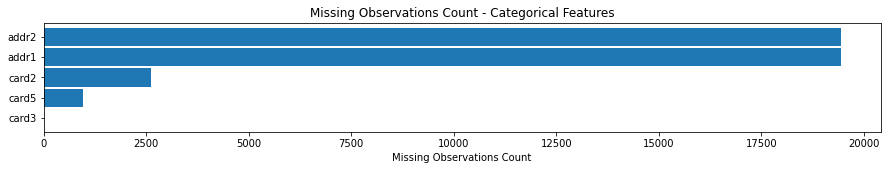

In [ ]:
missing_values = categorical_data[features_2].isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
fig, axes = plt.subplots(figsize=(15, 2))
rects = axes.barh(ind, missing_values.missing_count.values, height=0.9)
axes.set_yticks(ind)
axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
axes.set_title("Missing Observations Count - Categorical Features")
axes.set_xlabel("Missing Observations Count")

In [ ]:
categorical_data[features_2].describe()

,card1,card2,card3,card5,addr1,addr2
count,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000
mean,9860.225806,368.326897,153.410374,200.363089,291.160444,86.559903
std,4910.778205,158.952840,11.529483,40.585532,102.250385,3.958070
min,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000
25%,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000
50%,9633.000000,375.000000,150.000000,226.000000,299.000000,87.000000
75%,14182.000000,514.000000,150.000000,226.000000,330.000000,87.000000
max,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000


In [ ]:
# так как модель на деревьях, заменю пропуски близким по значению (можно было и поэксперементировать)
categorical_data[features_2] = categorical_data[features_2].fillna(9)
categorical_test_data[features_2] = categorical_test_data[features_2].fillna(9)

In [ ]:
categorical_data[features_2] = categorical_data[features_2].astype("int")
categorical_test_data[features_2] = categorical_test_data[features_2].astype("int")

In [ ]:
categorical_data["card_1_2"] = categorical_data["card1"].astype('str') + categorical_data["card2"].astype('str')
categorical_data["card_1_2_3_5"] = categorical_data["card_1_2"] +  categorical_data["card3"].astype('str') + categorical_data["card5"].astype('str')
categorical_data["card_1_2_3_5_addr_1_2"] = categorical_data["card_1_2_3_5"] + categorical_data["addr1"].astype('str') + categorical_data["addr2"].astype('str')

In [ ]:
categorical_test_data["card_1_2"] = categorical_test_data["card1"].astype('str') + categorical_test_data["card2"].astype('str')
categorical_test_data["card_1_2_3_5"] = categorical_test_data["card_1_2"] +  categorical_test_data["card3"].astype('str') + categorical_test_data["card5"].astype('str')
categorical_test_data["card_1_2_3_5_addr_1_2"] = categorical_test_data["card_1_2_3_5"] + categorical_test_data["addr1"].astype('str') + categorical_test_data["addr2"].astype('str')

In [ ]:
# categorical_data["card_1_2"] = categorical_data["card_1_2"].astype("category")
# categorical_data["card_1_2_3_5"] = categorical_data["card_1_2_3_5"].astype("category")
# categorical_data["card_1_2_3_5_addr_1_2"] = categorical_data["card_1_2_3_5_addr_1_2"].astype("category")

In [ ]:
# categorical_test_data["card_1_2"] = categorical_test_data["card_1_2"].astype("category")
# categorical_test_data["card_1_2_3_5"] = categorical_test_data["card_1_2_3_5"].astype("category")
# categorical_test_data["card_1_2_3_5_addr_1_2"] = categorical_test_data["card_1_2_3_5_addr_1_2"].astype("category")

In [ ]:
type(categorical_data["card_1_2_3_5_addr_1_2"][0])

str

In [ ]:
categorical_data[features_2].head(n=2)

,card1,card2,card3,card5,addr1,addr2
0,13926,9,150,142,315,87
1,2755,404,150,102,325,87


In [ ]:
categorical_data[["card1", "card2", "card_1_2", "card_1_2_3_5", "card_1_2_3_5_addr_1_2"]].head(n=2)

,card1,card2,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2
0,13926,9,139269,139269150142,13926915014231587
1,2755,404,2755404,2755404150102,275540415010232587


In [ ]:
x_train, x_valid = train_test_split(
    categorical_data.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.70, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    categorical_data["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_test = (categorical_test_data.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = categorical_test_data["isFraud"]

In [ ]:
le = LabelEncoder()
x_train["card_1_2_le_enc"]= le.fit_transform(x_train["card_1_2"])
x_train["card_1_2_3_5_le_enc"] = le.fit_transform(x_train["card_1_2_3_5"])
x_train["card_1_2_3_5_addr_1_2_le_enc"] = le.fit_transform(x_train["card_1_2_3_5_addr_1_2"])

le = LabelEncoder()
x_valid["card_1_2_le_enc"] = le.fit_transform(x_valid["card_1_2"])
x_valid["card_1_2_3_5_le_enc"] = le.fit_transform(x_valid["card_1_2_3_5"])
x_valid["card_1_2_3_5_addr_1_2_le_enc"] = le.fit_transform(x_valid["card_1_2_3_5_addr_1_2"])

le = LabelEncoder()
x_test["card_1_2_le_enc"] = le.fit_transform(x_test["card_1_2"])
x_test["card_1_2_3_5_le_enc"] = le.fit_transform(x_test["card_1_2_3_5"])
x_test["card_1_2_3_5_addr_1_2_le_enc"] = le.fit_transform(x_test["card_1_2_3_5_addr_1_2"])

In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 380 cols
x_valid.shape = 54001 rows, 380 cols
x_test.shape = 100001 rows, 380 cols


In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648969	test-auc:0.622315
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.794601	test-auc:0.756904
[20]	train-auc:0.834374	test-auc:0.804529
[30]	train-auc:0.863866	test-auc:0.842969
[40]	train-auc:0.87215	test-auc:0.850359
[50]	train-auc:0.878774	test-auc:0.854477
[60]	train-auc:0.884268	test-auc:0.856485
[70]	train-auc:0.887753	test-auc:0.858009
[80]	train-auc:0.890338	test-auc:0.859168
[90]	train-auc:0.892721	test-auc:0.859805
[100]	train-auc:0.894918	test-auc:0.860135
[110]	train-auc:0.896124	test-auc:0.860347
[120]	train-auc:0.896978	test-auc:0.860827
[130]	train-auc:0.898862	test-auc:0.86154
[140]	train-auc:0.89915	test-auc:0.861407
[150]	train-auc:0.89915	test-auc:0.861407
Stopping. Best iteration:
[127]	train-auc:0.898497	test-auc:0.861551



In [ ]:
train_roc_auc_score_2 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_2 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_2 = roc_auc_score(y_test, model.predict(dtest))

In [ ]:
print('train: %.4f' % train_roc_auc_score_2)
print('valid: %.4f' % valid_roc_auc_score_2)
print('test: %.4f' % test_roc_auc_score_2)

train: 0.8992
valid: 0.8835
test: 0.8614


Задание 3: Сделать FrequencyEncoder для признаков card1 - card6, addr1, addr2.



In [ ]:
categorical_data_fe = categorical_data.copy()
categorical_test_data_fe = categorical_test_data.copy()

In [ ]:
x_train, x_valid = train_test_split(
    categorical_data_fe.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.70, 
    shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    categorical_data_fe["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_test = (categorical_test_data_fe.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = categorical_test_data_fe["isFraud"]

In [ ]:
x_train.head(n=2)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,...,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2
59549,117.0,W,16132,111,150,visa,226,debit,264,87,NaN,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,2.0,0.0,4.0,2.0,211.0,211.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,211.0,NaN,NaN,...,0.0,0.0,1.0,0.0,117.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16132111,16132111150226,1613211115022626487
155490,20.0,H,5254,414,143,visa,226,debit,502,87,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,43.166664,0.166666,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5254414,5254414143226,525441414322650287


In [ ]:
x_train["card_1_2_freq_enc"]= x_train["card_1_2"].map(x_train["card_1_2"].value_counts(normalize=True))
x_train["card_1_2_3_5_freq_enc"] = x_train["card_1_2_3_5"].map(x_train["card_1_2_3_5"].value_counts(normalize=True))
x_train["card_1_2_3_5_addr_1_2_freq_enc"] = x_train["card_1_2_3_5_addr_1_2"].map(x_train["card_1_2_3_5_addr_1_2"].
                                                                                 value_counts(normalize=True))

x_valid["card_1_2_freq_enc"] = x_valid["card_1_2"].map(x_valid["card_1_2"].value_counts(normalize=True))
x_valid["card_1_2_3_5_freq_enc"] = x_valid["card_1_2_3_5"].map(x_valid["card_1_2_3_5"].value_counts(normalize=True))
x_valid["card_1_2_3_5_addr_1_2_freq_enc"] = x_valid["card_1_2_3_5_addr_1_2"].map(x_valid["card_1_2_3_5_addr_1_2"].
                                                                                 value_counts(normalize=True))

x_test["card_1_2_freq_enc"] = x_test["card_1_2"].map(x_test["card_1_2"].value_counts(normalize=True))
x_test["card_1_2_3_5_freq_enc"] = x_test["card_1_2_3_5"].map(x_test["card_1_2_3_5"].value_counts(normalize=True))
x_test["card_1_2_3_5_addr_1_2_freq_enc"] = x_test["card_1_2_3_5_addr_1_2"].map(x_test["card_1_2_3_5_addr_1_2"].
                                                                               value_counts(normalize=True))

In [ ]:
x_train.head(n=2)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,...,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2,card_1_2_freq_enc,card_1_2_3_5_freq_enc,card_1_2_3_5_addr_1_2_freq_enc
59549,117.0,W,16132,111,150,visa,226,debit,264,87,NaN,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,2.0,0.0,4.0,2.0,211.0,211.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,211.0,NaN,NaN,...,0.0,117.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16132111,16132111150226,1613211115022626487,0.006421,0.006421,0.000111
155490,20.0,H,5254,414,143,visa,226,debit,502,87,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,43.166664,0.166666,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5254414,5254414143226,525441414322650287,0.000476,0.000476,0.000310


In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 380 cols
x_valid.shape = 54001 rows, 380 cols
x_test.shape = 100001 rows, 380 cols


In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648969	test-auc:0.622315
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.79484	test-auc:0.756711
[20]	train-auc:0.834235	test-auc:0.803422
[30]	train-auc:0.860031	test-auc:0.840075
[40]	train-auc:0.870347	test-auc:0.848649
[50]	train-auc:0.879688	test-auc:0.854449
[60]	train-auc:0.884829	test-auc:0.857141
[70]	train-auc:0.88809	test-auc:0.857889
[80]	train-auc:0.890628	test-auc:0.858775
[90]	train-auc:0.892889	test-auc:0.859178
[100]	train-auc:0.894846	test-auc:0.860341
[110]	train-auc:0.896322	test-auc:0.86106
[120]	train-auc:0.89777	test-auc:0.86113
[130]	train-auc:0.899381	test-auc:0.861835
[140]	train-auc:0.900514	test-auc:0.861926
[150]	train-auc:0.901553	test-auc:0.862332
[160]	train-auc:0.901553	test-auc:0.862332
[170]	train-auc:0.901553	test-auc:0.862332
Stopping. Best iteration:
[147]	train-auc:0.901553	test-auc:0.862332



In [ ]:
train_roc_auc_score_3 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_3 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_3 = roc_auc_score(y_test, model.predict(dtest))

In [ ]:
print('train: %.4f' % train_roc_auc_score_3)
print('valid: %.4f' % valid_roc_auc_score_3)
print('test: %.4f' % test_roc_auc_score_3)

train: 0.9016
valid: 0.8857
test: 0.8623


Задание 4: Создать признаки на основе отношения: TransactionAmt к вычисленной статистике. Статистика - среднее значение / стандартное отклонение TransactionAmt, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.


In [ ]:
stats_data_4 = categorical_data.copy()
stats_test_data_4 = categorical_test_data.copy()

In [ ]:
def create_stats(data: pd.DataFrame, 
                 groupby_col: List[str], 
                 stat: List[str],
                 feature: [str]) -> pd.DataFrame:
    
    stats = data[groupby_col]
    stats[feature] = data[feature]
    for gr_columns in groupby_col:
        data_grouped = data.groupby(gr_columns)
        for i in stat:
            columns = f"{feature}_{i}_{gr_columns}".upper()
            stats[columns] = data_grouped[feature].transform(i)
            columns_relationship = columns + "_relationship"
            stats[columns_relationship] = stats[feature] / stats[columns]

    stats = stats.drop(groupby_col, axis=1)
    stats = stats.drop(feature, axis=1)
    stats = stats.fillna(-9999)
    # stats = stats.reset_index()
    
    return stats


In [ ]:
groupby_col = ["card1", "card2", "card3", "card5", "addr1", "addr2", "card_1_2", "card_1_2_3_5", "card_1_2_3_5_addr_1_2"] 
stat = ["mean", "std"]
stats_4 = create_stats(stats_data_4, groupby_col=groupby_col, stat=stat, feature="TransactionAmt") 

stats_4.head()

,TRANSACTIONAMT_MEAN_CARD1,TRANSACTIONAMT_MEAN_CARD1_relationship,TRANSACTIONAMT_STD_CARD1,TRANSACTIONAMT_STD_CARD1_relationship,TRANSACTIONAMT_MEAN_CARD2,TRANSACTIONAMT_MEAN_CARD2_relationship,TRANSACTIONAMT_STD_CARD2,TRANSACTIONAMT_STD_CARD2_relationship,TRANSACTIONAMT_MEAN_CARD3,TRANSACTIONAMT_MEAN_CARD3_relationship,TRANSACTIONAMT_STD_CARD3,TRANSACTIONAMT_STD_CARD3_relationship,TRANSACTIONAMT_MEAN_CARD5,TRANSACTIONAMT_MEAN_CARD5_relationship,TRANSACTIONAMT_STD_CARD5,TRANSACTIONAMT_STD_CARD5_relationship,TRANSACTIONAMT_MEAN_ADDR1,TRANSACTIONAMT_MEAN_ADDR1_relationship,TRANSACTIONAMT_STD_ADDR1,TRANSACTIONAMT_STD_ADDR1_relationship,TRANSACTIONAMT_MEAN_ADDR2,TRANSACTIONAMT_MEAN_ADDR2_relationship,TRANSACTIONAMT_STD_ADDR2,TRANSACTIONAMT_STD_ADDR2_relationship,TRANSACTIONAMT_MEAN_CARD_1_2,TRANSACTIONAMT_MEAN_CARD_1_2_relationship,TRANSACTIONAMT_STD_CARD_1_2,TRANSACTIONAMT_STD_CARD_1_2_relationship,TRANSACTIONAMT_MEAN_CARD_1_2_3_5,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_relationship,TRANSACTIONAMT_STD_CARD_1_2_3_5,TRANSACTIONAMT_STD_CARD_1_2_3_5_relationship,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_ADDR_1_2,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_ADDR_1_2_relationship,TRANSACTIONAMT_STD_CARD_1_2_3_5_ADDR_1_2,TRANSACTIONAMT_STD_CARD_1_2_3_5_ADDR_1_2_relationship
0,193.227273,0.354505,167.115733,0.409896,195.077321,0.351143,329.849448,0.207671,140.340757,0.488098,216.977741,0.315701,123.384490,0.555175,116.506517,0.587950,133.110424,0.514610,237.894612,0.287943,140.836345,0.486380,217.497586,0.314946,296.375000,0.231126,235.958109,0.290306,296.375000,0.231126,235.958109,0.290306,68.500000,1.000000,-9999.000000,-9999.000000
1,229.588080,0.126313,413.469295,0.070138,198.800100,0.145875,294.181782,0.098579,140.340757,0.206640,216.977741,0.133654,190.203414,0.152468,290.383922,0.099868,149.334343,0.194195,228.947057,0.126667,140.836345,0.205913,217.497586,0.133335,229.588080,0.126313,413.469295,0.070138,229.588080,0.126313,413.469295,0.070138,226.809524,0.127861,270.054718,0.107386
2,88.574163,0.666108,85.292070,0.691741,130.543067,0.451958,198.093268,0.297839,140.340757,0.420405,216.977741,0.271917,92.555617,0.637455,128.876007,0.457804,128.027695,0.460838,223.498760,0.263984,140.836345,0.418926,217.497586,0.271267,88.574163,0.666108,85.292070,0.691741,88.574163,0.666108,85.292070,0.691741,53.172727,1.109591,14.353664,4.110449
3,112.887660,0.442918,161.176299,0.310219,126.468333,0.395356,164.331289,0.304263,140.340757,0.356276,216.977741,0.230438,119.271582,0.419211,164.054412,0.304777,123.394726,0.405204,179.001399,0.279327,140.836345,0.355022,217.497586,0.229888,112.887660,0.442918,161.176299,0.310219,112.887660,0.442918,161.176299,0.310219,105.865315,0.472298,299.155602,0.167137
4,40.000000,1.250000,14.142136,3.535534,184.910881,0.270401,301.254071,0.165973,140.340757,0.356276,216.977741,0.230438,190.203414,0.262876,290.383922,0.172186,136.187935,0.367140,190.078361,0.263049,140.836345,0.355022,217.497586,0.229888,40.000000,1.250000,14.142136,3.535534,40.000000,1.250000,14.142136,3.535534,50.000000,1.000000,-9999.000000,-9999.000000


In [ ]:
stats_test_4 = create_stats(stats_test_data_4, groupby_col=groupby_col, stat=stat, feature="TransactionAmt")
stats_test_4.head()

,TRANSACTIONAMT_MEAN_CARD1,TRANSACTIONAMT_MEAN_CARD1_relationship,TRANSACTIONAMT_STD_CARD1,TRANSACTIONAMT_STD_CARD1_relationship,TRANSACTIONAMT_MEAN_CARD2,TRANSACTIONAMT_MEAN_CARD2_relationship,TRANSACTIONAMT_STD_CARD2,TRANSACTIONAMT_STD_CARD2_relationship,TRANSACTIONAMT_MEAN_CARD3,TRANSACTIONAMT_MEAN_CARD3_relationship,TRANSACTIONAMT_STD_CARD3,TRANSACTIONAMT_STD_CARD3_relationship,TRANSACTIONAMT_MEAN_CARD5,TRANSACTIONAMT_MEAN_CARD5_relationship,TRANSACTIONAMT_STD_CARD5,TRANSACTIONAMT_STD_CARD5_relationship,TRANSACTIONAMT_MEAN_ADDR1,TRANSACTIONAMT_MEAN_ADDR1_relationship,TRANSACTIONAMT_STD_ADDR1,TRANSACTIONAMT_STD_ADDR1_relationship,TRANSACTIONAMT_MEAN_ADDR2,TRANSACTIONAMT_MEAN_ADDR2_relationship,TRANSACTIONAMT_STD_ADDR2,TRANSACTIONAMT_STD_ADDR2_relationship,TRANSACTIONAMT_MEAN_CARD_1_2,TRANSACTIONAMT_MEAN_CARD_1_2_relationship,TRANSACTIONAMT_STD_CARD_1_2,TRANSACTIONAMT_STD_CARD_1_2_relationship,TRANSACTIONAMT_MEAN_CARD_1_2_3_5,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_relationship,TRANSACTIONAMT_STD_CARD_1_2_3_5,TRANSACTIONAMT_STD_CARD_1_2_3_5_relationship,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_ADDR_1_2,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_ADDR_1_2_relationship,TRANSACTIONAMT_STD_CARD_1_2_3_5_ADDR_1_2,TRANSACTIONAMT_STD_CARD_1_2_3_5_ADDR_1_2_relationship
0,280.968750,0.804360,62.942106,3.590601,134.014967,1.686379,212.923901,1.061412,152.975555,1.477360,251.6378,0.898116,149.66531,1.510036,249.636836,0.905315,189.374905,1.193400,291.457052,0.775414,154.076553,1.466803,252.968071,0.893393,280.968750,0.804360,62.942106,3.590601,280.968750,0.804360,62.942106,3.590601,280.968750,0.804360,62.942106,3.590601
1,108.544349,28.301796,243.568089,12.612490,120.185131,25.560566,231.167765,13.289050,152.975555,20.081640,251.6378,12.208023,149.66531,20.525798,249.636836,12.305876,131.025545,23.445810,216.060033,14.218271,154.076553,19.938141,252.968071,12.143825,108.769588,28.243189,244.454676,12.566747,108.769588,28.243189,244.454676,12.566747,107.802984,28.496428,252.073024,12.186945
2,577.700732,0.553833,950.931225,0.336460,299.443997,1.068480,497.364728,0.643290,152.975555,2.091511,251.6378,1.271470,149.66531,2.137770,249.636836,1.281662,164.706213,1.942550,277.898073,1.151321,154.076553,2.076565,252.968071,1.264784,577.700732,0.553833,950.931225,0.336460,577.700732,0.553833,950.931225,0.336460,215.316667,1.485951,110.363494,2.899056
3,246.688182,0.693183,406.753469,0.420402,246.688182,0.693183,406.753469,0.420402,152.975555,1.117826,251.6378,0.679548,149.66531,1.142549,249.636836,0.684995,162.115358,1.054804,269.613507,0.634241,154.076553,1.109838,252.968071,0.675975,246.688182,0.693183,406.753469,0.420402,246.688182,0.693183,406.753469,0.420402,246.688182,0.693183,406.753469,0.420402
4,66.985714,1.611538,31.277797,3.451330,134.014967,0.805507,212.923901,0.506989,152.975555,0.705668,251.6378,0.428990,149.66531,0.721276,249.636836,0.432428,137.743399,0.783704,234.963159,0.459434,154.076553,0.700626,252.968071,0.426734,66.985714,1.611538,31.277797,3.451330,66.985714,1.611538,31.277797,3.451330,66.985714,1.611538,31.277797,3.451330


In [ ]:
features_4 = stats_4.columns
# features_4
stats_data_4[features_4] = stats_4
stats_test_data_4[features_4] =stats_test_4


In [ ]:
stats_data_4.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V339,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2,TRANSACTIONAMT_MEAN_CARD1,TRANSACTIONAMT_MEAN_CARD1_relationship,TRANSACTIONAMT_STD_CARD1,TRANSACTIONAMT_STD_CARD1_relationship,TRANSACTIONAMT_MEAN_CARD2,TRANSACTIONAMT_MEAN_CARD2_relationship,TRANSACTIONAMT_STD_CARD2,TRANSACTIONAMT_STD_CARD2_relationship,TRANSACTIONAMT_MEAN_CARD3,TRANSACTIONAMT_MEAN_CARD3_relationship,TRANSACTIONAMT_STD_CARD3,TRANSACTIONAMT_STD_CARD3_relationship,TRANSACTIONAMT_MEAN_CARD5,TRANSACTIONAMT_MEAN_CARD5_relationship,TRANSACTIONAMT_STD_CARD5,TRANSACTIONAMT_STD_CARD5_relationship,TRANSACTIONAMT_MEAN_ADDR1,TRANSACTIONAMT_MEAN_ADDR1_relationship,TRANSACTIONAMT_STD_ADDR1,TRANSACTIONAMT_STD_ADDR1_relationship,TRANSACTIONAMT_MEAN_ADDR2,TRANSACTIONAMT_MEAN_ADDR2_relationship,TRANSACTIONAMT_STD_ADDR2,TRANSACTIONAMT_STD_ADDR2_relationship,TRANSACTIONAMT_MEAN_CARD_1_2,TRANSACTIONAMT_MEAN_CARD_1_2_relationship,TRANSACTIONAMT_STD_CARD_1_2,TRANSACTIONAMT_STD_CARD_1_2_relationship,TRANSACTIONAMT_MEAN_CARD_1_2_3_5,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_relationship,TRANSACTIONAMT_STD_CARD_1_2_3_5,TRANSACTIONAMT_STD_CARD_1_2_3_5_relationship,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_ADDR_1_2,TRANSACTIONAMT_MEAN_CARD_1_2_3_5_ADDR_1_2_relationship,TRANSACTIONAMT_STD_CARD_1_2_3_5_ADDR_1_2,TRANSACTIONAMT_STD_CARD_1_2_3_5_ADDR_1_2_relationship
0,2987000,0,86400,68.5,W,13926,9,150,discover,142,credit,315,87,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,139269,139269150142,13926915014231587,193.227273,0.354505,167.115733,0.409896,195.077321,0.351143,329.849448,0.207671,140.340757,0.488098,216.977741,0.315701,123.384490,0.555175,116.506517,0.587950,133.110424,0.514610,237.894612,0.287943,140.836345,0.486380,217.497586,0.314946,296.37500,0.231126,235.958109,0.290306,296.37500,0.231126,235.958109,0.290306,68.500000,1.000000,-9999.000000,-9999.000000
1,2987001,0,86401,29.0,W,2755,404,150,mastercard,102,credit,325,87,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,2755404,2755404150102,275540415010232587,229.588080,0.126313,413.469295,0.070138,198.800100,0.145875,294.181782,0.098579,140.340757,0.206640,216.977741,0.133654,190.203414,0.152468,290.383922,0.099868,149.334343,0.194195,228.947057,0.126667,140.836345,0.205913,217.497586,0.133335,229.58808,0.126313,413.469295,0.070138,229.58808,0.126313,413.469295,0.070138,226.809524,0.127861,270.054718,0.107386


In [ ]:
x_train, x_valid = train_test_split(
    stats_data_4.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.70, 
    shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    stats_data_4["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_test = (stats_test_data_4.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = stats_test_data_4["isFraud"]

In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 413 cols
x_valid.shape = 54001 rows, 413 cols
x_test.shape = 100001 rows, 413 cols


In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648969	test-auc:0.622315
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.794602	test-auc:0.756905
[20]	train-auc:0.834468	test-auc:0.804291
[30]	train-auc:0.860437	test-auc:0.841077
[40]	train-auc:0.873374	test-auc:0.850037
[50]	train-auc:0.8809	test-auc:0.855845
[60]	train-auc:0.886611	test-auc:0.857881
[70]	train-auc:0.890391	test-auc:0.860004
[80]	train-auc:0.894091	test-auc:0.860962
[90]	train-auc:0.896682	test-auc:0.861357
[100]	train-auc:0.899263	test-auc:0.862075
[110]	train-auc:0.901098	test-auc:0.862037
[120]	train-auc:0.902852	test-auc:0.862736
[130]	train-auc:0.904803	test-auc:0.862765
[140]	train-auc:0.906205	test-auc:0.862118
[150]	train-auc:0.907659	test-auc:0.862186
Stopping. Best iteration:
[129]	train-auc:0.904541	test-auc:0.862826



In [ ]:
train_roc_auc_score_4 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_4 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_4 = roc_auc_score(y_test, model.predict(dtest))

In [ ]:
print('train: %.4f' % train_roc_auc_score_4)
print('valid: %.4f' % valid_roc_auc_score_4)
print('test: %.4f' % test_roc_auc_score_4)

train: 0.9080
valid: 0.8929
test: 0.8619


Задание 5: Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.



In [ ]:
stats_data_5 = categorical_data.copy()
stats_test_data_5 = categorical_test_data.copy()

In [ ]:
stats_5 = create_stats(stats_data_5, groupby_col=groupby_col, stat=stat, feature="D15") 

stats_5.head(n=2)

,D15_MEAN_CARD1,D15_MEAN_CARD1_relationship,D15_STD_CARD1,D15_STD_CARD1_relationship,D15_MEAN_CARD2,D15_MEAN_CARD2_relationship,D15_STD_CARD2,D15_STD_CARD2_relationship,D15_MEAN_CARD3,D15_MEAN_CARD3_relationship,D15_STD_CARD3,D15_STD_CARD3_relationship,D15_MEAN_CARD5,D15_MEAN_CARD5_relationship,D15_STD_CARD5,D15_STD_CARD5_relationship,D15_MEAN_ADDR1,D15_MEAN_ADDR1_relationship,D15_STD_ADDR1,D15_STD_ADDR1_relationship,D15_MEAN_ADDR2,D15_MEAN_ADDR2_relationship,D15_STD_ADDR2,D15_STD_ADDR2_relationship,D15_MEAN_CARD_1_2,D15_MEAN_CARD_1_2_relationship,D15_STD_CARD_1_2,D15_STD_CARD_1_2_relationship,D15_MEAN_CARD_1_2_3_5,D15_MEAN_CARD_1_2_3_5_relationship,D15_STD_CARD_1_2_3_5,D15_STD_CARD_1_2_3_5_relationship,D15_MEAN_CARD_1_2_3_5_ADDR_1_2,D15_MEAN_CARD_1_2_3_5_ADDR_1_2_relationship,D15_STD_CARD_1_2_3_5_ADDR_1_2,D15_STD_CARD_1_2_3_5_ADDR_1_2_relationship
0,0.400000,0.0,0.547723,0.0,122.316408,0.0,166.482818,0.0,168.46659,0.0,186.337996,0.0,101.575758,0.0,142.176613,0.0,188.936614,0.0,194.069187,0.0,169.541518,0.0,186.33749,0.0,0.500000,0.0,0.577350,0.0,0.500000,0.0,0.577350,0.0,0.00,-9999.0,-9999.000000,-9999.0
1,114.811765,0.0,177.751006,0.0,123.450725,0.0,173.075974,0.0,168.46659,0.0,186.337996,0.0,110.602067,0.0,171.390409,0.0,195.737281,0.0,194.440057,0.0,169.541518,0.0,186.33749,0.0,114.811765,0.0,177.751006,0.0,114.811765,0.0,177.751006,0.0,59.75,0.0,123.056897,0.0


In [ ]:
stats_test_5 = create_stats(stats_test_data_5, groupby_col=groupby_col, stat=stat, feature="D15")
stats_test_5.head(n=2)

,D15_MEAN_CARD1,D15_MEAN_CARD1_relationship,D15_STD_CARD1,D15_STD_CARD1_relationship,D15_MEAN_CARD2,D15_MEAN_CARD2_relationship,D15_STD_CARD2,D15_STD_CARD2_relationship,D15_MEAN_CARD3,D15_MEAN_CARD3_relationship,D15_STD_CARD3,D15_STD_CARD3_relationship,D15_MEAN_CARD5,D15_MEAN_CARD5_relationship,D15_STD_CARD5,D15_STD_CARD5_relationship,D15_MEAN_ADDR1,D15_MEAN_ADDR1_relationship,D15_STD_ADDR1,D15_STD_ADDR1_relationship,D15_MEAN_ADDR2,D15_MEAN_ADDR2_relationship,D15_STD_ADDR2,D15_STD_ADDR2_relationship,D15_MEAN_CARD_1_2,D15_MEAN_CARD_1_2_relationship,D15_STD_CARD_1_2,D15_STD_CARD_1_2_relationship,D15_MEAN_CARD_1_2_3_5,D15_MEAN_CARD_1_2_3_5_relationship,D15_STD_CARD_1_2_3_5,D15_STD_CARD_1_2_3_5_relationship,D15_MEAN_CARD_1_2_3_5_ADDR_1_2,D15_MEAN_CARD_1_2_3_5_ADDR_1_2_relationship,D15_STD_CARD_1_2_3_5_ADDR_1_2,D15_STD_CARD_1_2_3_5_ADDR_1_2_relationship
0,3.968750,0.755906,1.121185,2.67574,158.837278,0.018887,204.026369,0.014704,169.91188,0.017656,205.197875,0.01462,178.862367,0.016773,209.302675,0.014333,160.912203,0.018644,203.203252,0.014764,171.017543,0.017542,205.442135,0.014603,3.96875,0.755906,1.121185,2.67574,3.96875,0.755906,1.121185,2.67574,3.968750,0.755906,1.121185,2.67574
1,185.539474,0.000000,205.447386,0.00000,173.682927,0.000000,200.105624,0.000000,169.91188,0.000000,205.197875,0.00000,178.862367,0.000000,209.302675,0.000000,180.925192,0.000000,209.841683,0.000000,171.017543,0.000000,205.442135,0.000000,185.60177,0.000000,205.670007,0.00000,185.60177,0.000000,205.670007,0.00000,181.763285,0.000000,208.448282,0.00000


In [ ]:
features_5 = stats_5.columns
# features_4
stats_data_5[features_5] = stats_5
stats_test_data_5[features_5] = stats_test_5

In [ ]:
stats_data_5.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V339,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2,D15_MEAN_CARD1,D15_MEAN_CARD1_relationship,D15_STD_CARD1,D15_STD_CARD1_relationship,D15_MEAN_CARD2,D15_MEAN_CARD2_relationship,D15_STD_CARD2,D15_STD_CARD2_relationship,D15_MEAN_CARD3,D15_MEAN_CARD3_relationship,D15_STD_CARD3,D15_STD_CARD3_relationship,D15_MEAN_CARD5,D15_MEAN_CARD5_relationship,D15_STD_CARD5,D15_STD_CARD5_relationship,D15_MEAN_ADDR1,D15_MEAN_ADDR1_relationship,D15_STD_ADDR1,D15_STD_ADDR1_relationship,D15_MEAN_ADDR2,D15_MEAN_ADDR2_relationship,D15_STD_ADDR2,D15_STD_ADDR2_relationship,D15_MEAN_CARD_1_2,D15_MEAN_CARD_1_2_relationship,D15_STD_CARD_1_2,D15_STD_CARD_1_2_relationship,D15_MEAN_CARD_1_2_3_5,D15_MEAN_CARD_1_2_3_5_relationship,D15_STD_CARD_1_2_3_5,D15_STD_CARD_1_2_3_5_relationship,D15_MEAN_CARD_1_2_3_5_ADDR_1_2,D15_MEAN_CARD_1_2_3_5_ADDR_1_2_relationship,D15_STD_CARD_1_2_3_5_ADDR_1_2,D15_STD_CARD_1_2_3_5_ADDR_1_2_relationship
0,2987000,0,86400,68.5,W,13926,9,150,discover,142,credit,315,87,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,139269,139269150142,13926915014231587,0.400000,0.0,0.547723,0.0,122.316408,0.0,166.482818,0.0,168.46659,0.0,186.337996,0.0,101.575758,0.0,142.176613,0.0,188.936614,0.0,194.069187,0.0,169.541518,0.0,186.33749,0.0,0.500000,0.0,0.577350,0.0,0.500000,0.0,0.577350,0.0,0.00,-9999.0,-9999.000000,-9999.0
1,2987001,0,86401,29.0,W,2755,404,150,mastercard,102,credit,325,87,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,2755404,2755404150102,275540415010232587,114.811765,0.0,177.751006,0.0,123.450725,0.0,173.075974,0.0,168.46659,0.0,186.337996,0.0,110.602067,0.0,171.390409,0.0,195.737281,0.0,194.440057,0.0,169.541518,0.0,186.33749,0.0,114.811765,0.0,177.751006,0.0,114.811765,0.0,177.751006,0.0,59.75,0.0,123.056897,0.0


In [ ]:
x_train, x_valid = train_test_split(
    stats_data_5.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.70, 
    shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    stats_data_5["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_test = (stats_test_data_5.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = stats_test_data_5["isFraud"]

In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 413 cols
x_valid.shape = 54001 rows, 413 cols
x_test.shape = 100001 rows, 413 cols


In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648965	test-auc:0.622315
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.7948	test-auc:0.75569
[20]	train-auc:0.833997	test-auc:0.804267
[30]	train-auc:0.862947	test-auc:0.842311
[40]	train-auc:0.872106	test-auc:0.850185
[50]	train-auc:0.87931	test-auc:0.853558
[60]	train-auc:0.884998	test-auc:0.855311
[70]	train-auc:0.889129	test-auc:0.856101
[80]	train-auc:0.892335	test-auc:0.856955
[90]	train-auc:0.895456	test-auc:0.857347
[100]	train-auc:0.897209	test-auc:0.858175
[110]	train-auc:0.899307	test-auc:0.858587
[120]	train-auc:0.901157	test-auc:0.858746
[130]	train-auc:0.902544	test-auc:0.858114
[140]	train-auc:0.904163	test-auc:0.858835
[150]	train-auc:0.905482	test-auc:0.858363
[160]	train-auc:0.906553	test-auc:0.858844
Stopping. Best iteration:
[139]	train-auc:0.904087	test-auc:0.858875



In [ ]:
train_roc_auc_score_5 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_5 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_5 = roc_auc_score(y_test, model.predict(dtest))

In [ ]:
print('train: %.4f' % train_roc_auc_score_5)
print('valid: %.4f' % valid_roc_auc_score_5)
print('test: %.4f' % test_roc_auc_score_5)

train: 0.9066
valid: 0.8907
test: 0.8588


Задание 6: выделить дробную часть и целую часть признака TransactionAmt в два отдельных признака. После создать отдельный признак - логарифм от TransactionAmt


In [ ]:
stats_data_6 = categorical_data.copy()
stats_test_data_6 = categorical_test_data.copy()

In [ ]:
def create_stats_6(data: pd.DataFrame, 
                 feature: [str]) -> pd.DataFrame:
    
    stats = data.copy()
    stats["TransactionAmt_int"] = (stats["TransactionAmt"] // 1).astype(int)
    stats["TransactionAmt_frac"] = stats["TransactionAmt"] - stats["TransactionAmt_int"]
    stats["TransactionAmt_log"] = np.log(stats["TransactionAmt"])

    # stats = stats.reset_index()
    
    return stats

In [ ]:
stats_6 = create_stats_6(stats_data_6, "TransactionAmt")
stats_6.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
0,2987000,0,86400,68.5,W,13926,9,150,discover,142,credit,315,87,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139269,139269150142,13926915014231587,68,0.5,4.226834
1,2987001,0,86401,29.0,W,2755,404,150,mastercard,102,credit,325,87,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2755404,2755404150102,275540415010232587,29,0.0,3.367296


In [ ]:
feature_6 = ["TransactionAmt_int", "TransactionAmt_frac", "TransactionAmt_log"]
# stats_6[["TransactionAmt", "TransactionAmt_int", "TransactionAmt_frac", "TransactionAmt_log"]]

,TransactionAmt,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
0,68.50,68,0.50,4.226834
1,29.00,29,0.00,3.367296
2,59.00,59,0.00,4.077537
3,50.00,50,0.00,3.912023
4,50.00,50,0.00,3.912023
...,...,...,...,...
179995,39.00,39,0.00,3.663562
179996,59.95,59,0.95,4.093511
179997,34.00,34,0.00,3.526361
179998,59.00,59,0.00,4.077537


In [ ]:
stats_test_6 = create_stats_6(stats_test_data_6, "TransactionAmt")
stats_test_6.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
0,3287000,1,7415038,226.0,W,12473,555,150,visa,226,credit,299,87,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,...,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12473555,12473555150226,1247355515022629987,226,0.0,5.420535
1,3287001,0,7415054,3072.0,W,15651,417,150,visa,226,debit,330,87,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,3059.949951,3059.949951,3059.949951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3059.949951,3059.949951,3059.949951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15651417,15651417150226,1565141715022633087,3072,0.0,8.030084


In [ ]:
x_train, x_valid = train_test_split(
    stats_6.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.70, 
    shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    stats_6["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_test = (stats_test_6.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = stats_test_6["isFraud"]

In [ ]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 380 cols
x_valid.shape = 54001 rows, 380 cols
x_test.shape = 100001 rows, 380 cols


In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648969	test-auc:0.622315
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.794601	test-auc:0.756904
[20]	train-auc:0.834374	test-auc:0.804529
[30]	train-auc:0.863866	test-auc:0.842969
[40]	train-auc:0.871462	test-auc:0.850211
[50]	train-auc:0.877671	test-auc:0.853307
[60]	train-auc:0.883707	test-auc:0.857506
[70]	train-auc:0.886823	test-auc:0.857521
[80]	train-auc:0.889034	test-auc:0.858436
[90]	train-auc:0.891963	test-auc:0.858618
[100]	train-auc:0.894114	test-auc:0.858999
[110]	train-auc:0.895335	test-auc:0.859902
[120]	train-auc:0.895615	test-auc:0.860085
[130]	train-auc:0.895615	test-auc:0.860085
Stopping. Best iteration:
[113]	train-auc:0.895615	test-auc:0.860085



In [ ]:
train_roc_auc_score_6 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_6 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_6 = roc_auc_score(y_test, model.predict(dtest))

In [ ]:
print('train: %.4f' % train_roc_auc_score_5)
print('valid: %.4f' % valid_roc_auc_score_5)
print('test: %.4f' % test_roc_auc_score_5)

train: 0.9066
valid: 0.8907
test: 0.8588


In [ ]:
print('test0: %.4f' % test_roc_auc_score_0)
print('test1: %.4f' % test_roc_auc_score_1)
print('test2: %.4f' % test_roc_auc_score_2)
print('test3: %.4f' % test_roc_auc_score_3)
print('test4: %.4f' % test_roc_auc_score_4)
print('test5: %.4f' % test_roc_auc_score_5)
print('test6: %.4f' % test_roc_auc_score_6)

test0: 0.8606
test1: 0.8588
test2: 0.8614
test3: 0.8623
test4: 0.8619
test5: 0.8588
test6: 0.8601


Задание 7 (опция): выполнить предварительную подготовку / очистку признаков P_emaildomain и R_emaildomain (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.
